In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from torch.utils.data import Dataset

In [2]:
# Step 1: Load and Preprocess Data
fake = pd.read_csv("C:/Users/OMEN/Desktop/FakeNews_Best_Model/archive/Fake.csv")
true = pd.read_csv("C:/Users/OMEN/Desktop/FakeNews_Best_Model/archive/True.csv")

In [3]:
# Drop irrelevant columns
fake.drop(['subject', 'date'], axis=1, inplace=True)
true.drop(['subject', 'date'], axis=1, inplace=True)
# Assign labels
fake['label'] = 1
true['label'] = 0

In [4]:
# Combine and shuffle
data = pd.concat([fake, true], axis=0).sample(frac=1).reset_index(drop=True)
data.fillna(' ', inplace=True)

In [5]:
# Extract raw text and labels
texts = data['text'].tolist()
labels = data['label'].tolist()

In [6]:
# 🔻 Optional: use small subset for fast training
texts = texts[:2000]
labels = labels[:2000]

In [7]:
# Step 2: Train/Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [8]:
# Step 2: Load small BERT model
model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Step 3: Tokenize (shorter sequence for speed)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

class FakeNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {
            "labels": torch.tensor(self.labels[idx])
        }
    def __len__(self):
        return len(self.labels)

train_dataset = FakeNewsDataset(train_encodings, train_labels)
val_dataset = FakeNewsDataset(val_encodings, val_labels)

In [12]:
# Step 4: Training settings
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

c:\Users\OMEN\anaconda3\envs\BERT\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
# Step 5: Train and evaluate
trainer.train()
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Epoch,Training Loss,Validation Loss
1,0.392600,0.338757
2,0.245400,0.215380


Evaluation Results: {'eval_loss': 0.2153802514076233, 'eval_runtime': 0.147, 'eval_samples_per_second': 2721.846, 'eval_steps_per_second': 170.115, 'epoch': 2.0}


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [18]:
from sklearn.metrics import classification_report

# Get model predictions
predictions = trainer.predict(val_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)

# Display classification metrics
print(classification_report(val_labels, predicted_labels, target_names=["True", "Fake"]))

              precision    recall  f1-score   support

        True       0.98      1.00      0.99       178
        Fake       1.00      0.98      0.99       222

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



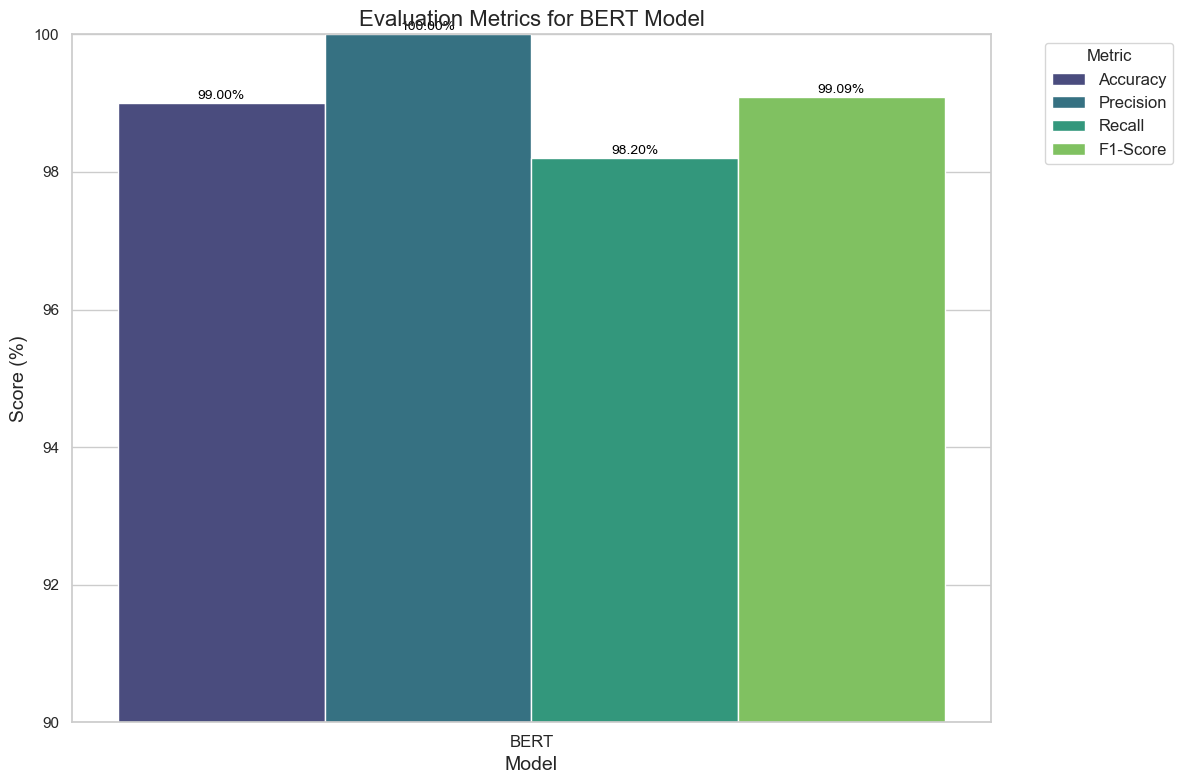

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate metrics
accuracy = accuracy_score(val_labels, predicted_labels) * 100
precision = precision_score(val_labels, predicted_labels) * 100
recall = recall_score(val_labels, predicted_labels) * 100
f1 = f1_score(val_labels, predicted_labels) * 100

# Create a DataFrame for scores
scores = pd.DataFrame({
    'Model': ['BERT'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1]
})

# Melt the DataFrame for visualization
scores_melted = scores.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot the metrics
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Model', y='Score', hue='Metric', data=scores_melted, palette='viridis', width=0.9)

plt.ylim(90, 100)  # Adjust the range as needed

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.2f}%',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        fontsize=10,
        color='black',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.xticks(fontsize=12)

plt.xlabel('Model', fontsize=14)
plt.ylabel('Score (%)', fontsize=14)
plt.title('All Metrics', fontsize=16)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=12)

plt.tight_layout()
plt.show()